# Value at Risk - Single Stock

VaR is defined as the minimum amount of cash that must be added to a portfolio of asset(s) to keep the probability of a negative return below a certain threshold $\alpha$.

$$VaR(X) = \inf\{m: P(X + m < 0) < \alpha \}$$

It is more commonly defined as the maximum expected possible loss over a specific time frame under a certain confidence threshold (Investopedia, 2024).

Example 1: At a 95% confidence level, what is the maximum loss I can be expected to make over the next 12 months?

Example 2: 1-year VaR of a \$1m at a 95\% confidence level $\leftrightarrow$ With 95% confidence, loss over the next year will be smaller or equal to \$1m.

There are three key techniques to determine the Value at Risk, namely the historical, variance-covariance / normal / parametric (using SMA or EWMA volatility), and monte carlo method. This project attempts to evaluate the three techniques to calculate VaR for NVIDIA, Apple, and Microsoft.

In [ ]:
import pandas as pd
import yfinance as yf
from datetime import date, timedelta
import numpy as np
import scipy.stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

### 1. Historical Method

The historical method looks at the returns of the asset over a given time window in the past, sorting them from worst to best. For a $(1-\alpha)\%$-confidence level, the historical VaR produces the return of the $\alpha$-th quartile of the sorted returns.

Key Assumption: profits/losses (returns) for the next period are distributed according to the returns of the previous period.

### 2a. Variance-Covariance / Normal Distribution / Parametric Method [using Simple Moving Average (SMA)]
This technique assumes that the returns of the asset are normally distributed with mean and variance given by the mean $\mu$ and variance $\sigma^2$ of the returns over a time period. Consequently, this technique returns the $\alpha$-th quartile of the normal distribution N($\mu$,$\sigma^2$) (Thakar, 2022).

Key Assumption: Returns or Log Returns are normally distributed.

### 2b. Variance-Covariance / Normal Distribution / Parametric Method [using Exponential Weighted Moving Average (EWMA)]

The EWMA Volatility approach to calculating VaR improves on the historical and parametric approaches as we no longer gives equal weighting to all the previous returns, but rather gives more importance to data from the recent past and less to returns further back in time (Investopedia, 2022).

In the historical approach, the returns are calculated for a given number of days from which the quantile is identified, with all returns having equal weighting. Moreover, the parametric approach assumes that the log returns is normally distributed with mean given by the sample mean of the past returns and scale given by the sample standard deviation, ie Simple Moving Average, of the past returns. 

$$
\text{SMA at time t: } \sigma^2_t(SMA) = E[(r_t - E(r_t))^2] \approx E[(r_t)^2] = \frac{1}{m} \sum_{k=1}^{m} r_k^2 = \frac{1}{m} \sum_{k=1}^{m} (\ln(\frac{S_{t-k}}{S_{t-k-1}}))^2
$$

where the approximation holds because expected daily returns $\approx 0$.

The EWMA, on the other hand, calculates the volatility (ie standard deviation) differently by allocating weights to each return for a given number of days m in the past. In the formula for simple variance, each return is given the same weighting $\frac{1}{m}$.

$$
\text{EWMA at time t: } \sigma^2_t(EWMA) \approx \sum_{k=1}^{m} (1-\lambda)\lambda^{k-1}r_k^2 = (1-\lambda) \sum_{k=1}^{m} \lambda^{k-1}(\ln(\frac{S_{t-k}}{S_{t-k-1}}))^2
$$

This can be shown to be equal to the recursive formula (Investopedia, 2022):

$$
\sigma^2_t(EWMA) = \lambda \sigma^2_{t-1} + (1-\lambda) r^2_{t-1}
$$

### 3. Monte Carlo (MC) Method

In [408]:
class Asset:

    def __init__(self, ticker, asset_class, past_data=None):
        self.asset_class = asset_class
        self.ticker = ticker
        self.past_data = past_data

    def retrieve_past_data(self, length):
        self.past_data = yf.download(self.ticker, start=str(date.today()- timedelta(days=length)), end=str(date.today()), auto_adjust=True)
        return self


    def calculate_returns(self):
        if self.past_data is not None:
            self.past_data['Returns'] = self.past_data['Close'].pct_change()
            self.past_data['Log Returns'] = np.log(self.past_data['Returns'] + 1)
        else:
            print('Error: No past data has been retrieved for this asset')
        return self

    def calculate_ewma_volatility(self, lambda_weight=0.94):
        self.calculate_returns()
        if self.past_data is not None:
            returns = self.past_data['Log Returns']
            square_return = (returns**2).values
            ewma_variance = np.zeros(len(square_return))
            for r in range(1, len(square_return)):
                ewma_variance[r] = (1-lambda_weight)*square_return[r] + lambda_weight*ewma_variance[r-1]
            ewma_volatility = np.sqrt(ewma_variance)
            self.past_data['EWMA_Volatility'] = pd.Series(ewma_volatility, index=returns.index, name ="EWMA Vol {}".format(lambda_weight))[1:]
            return self
        else:
            print('Error: No past data has been retrieved for this asset')


    def calculate_historical_var(self, days=360, log_return=True, confidence_level=0.95):
        data_size = self.past_data.shape[0]
        self.calculate_returns()
        try:
            list_ = []
            self.past_data['Historical VaR'] = None                   
            if log_return:
                for i in range(days, data_size):
                    var = round(self.past_data['Log Returns'][i-days:i].quantile(1-confidence_level), 3)
                    self.past_data.iloc[i,  self.past_data.columns.get_loc('Historical VaR')] = var
                return self
            else:
                for i in range(days, data_size):
                    var = round(self.past_data['Returns'][i-days:i].quantile(1-confidence_level), 3)
                    self.past_data.iloc[i,  self.past_data.columns.get_loc('Historical VaR')] = var
                return self 
        except:
            print('Error: No past data has been retrieved for this asset')

    def calculate_normal_var(self, days=360, log_return=True, confidence_level=0.95):
        data_size = self.past_data.shape[0]
        self.calculate_returns()
        try:
            self.past_data['Normal Distribution VaR'] = None                   
            if log_return:
                for i in range(days, data_size):
                    mean_ = np.mean(self.past_data['Log Returns'][i-days:i])
                    sd_ = np.std(self.past_data['Log Returns'][i-days:i])
                    var = round(scipy.stats.norm.ppf(1-confidence_level, loc=mean_, scale=sd_), 3)
                    self.past_data.iloc[i, self.past_data.columns.get_loc('Normal Distribution VaR')] = var
                return self
            else:
                for i in range(days, data_size):
                    mean_ = np.mean(self.past_data['Returns'][i-days:i])
                    sd_ = np.std(self.past_data['Returns'][i-days:i])
                    var = round(scipy.stats.norm.ppf(1-confidence_level, loc=mean_, scale=sd_), 3)
                    self.past_data.iloc[i, self.past_data.columns.get_loc('Normal Distribution VaR')] = var
                return self 
        except:
            print('Error: No past data has been retrieved for this asset')

    def calculate_ewma_var(self, ewma_lambda=0.94, confidence_level=0.95):
        data_size = self.past_data.shape[0]
        self.calculate_ewma_volatility(ewma_lambda)
        self.past_data['EWMA VaR'] = None
        for i in range(0, data_size):
            ewma_var = round(scipy.stats.norm.ppf(1-confidence_level, loc=0, scale=self.past_data.iloc[i]['EWMA_Volatility']), 3)   
            self.past_data.iloc[i, self.past_data.columns.get_loc('EWMA VaR')] = ewma_var
        return self
    
    def plot_var_graphs(self, days=360, confidence_level=0.95, x_axis=720, ewma_lambda=0.94, log_return=True, show_return=True):
        self.calculate_returns()
        self.calculate_historical_var(days=days, log_return=log_return, confidence_level=confidence_level)
        self.calculate_normal_var(days=days, log_return=log_return, confidence_level=confidence_level)
        self.calculate_ewma_var(ewma_lambda=ewma_lambda, confidence_level=confidence_level)
        historical_var_values = self.past_data['Historical VaR'][-(x_axis-days):]
        normal_var_values = self.past_data['Normal Distribution VaR'][-(x_axis-days):]
        ewma_var_values = self.past_data['EWMA VaR'][-(x_axis-days):]
        plt.figure(figsize=(20,8))
        plt.title(f'({days}-days) Historical, Variance-Covariance, & EWMA VaR for the past {x_axis-days} days at {confidence_level*100}% confidence')
        plt.plot(self.past_data.index[-(x_axis-days):], historical_var_values, label='Historical VaR')
        plt.plot(self.past_data.index[-(x_axis-days):], normal_var_values, label='Variance-Covariance VaR')
        plt.plot(self.past_data.index[-(x_axis-days):], ewma_var_values, label='EWMA VaR')
        if show_return:
            plt.plot(self.past_data.index[-(x_axis-days):], self.past_data['Log Returns'][-(x_axis-days):], label='Daily Return')
        plt.legend(loc='upper right')
        plt.show()

[*********************100%%**********************]  1 of 1 completed


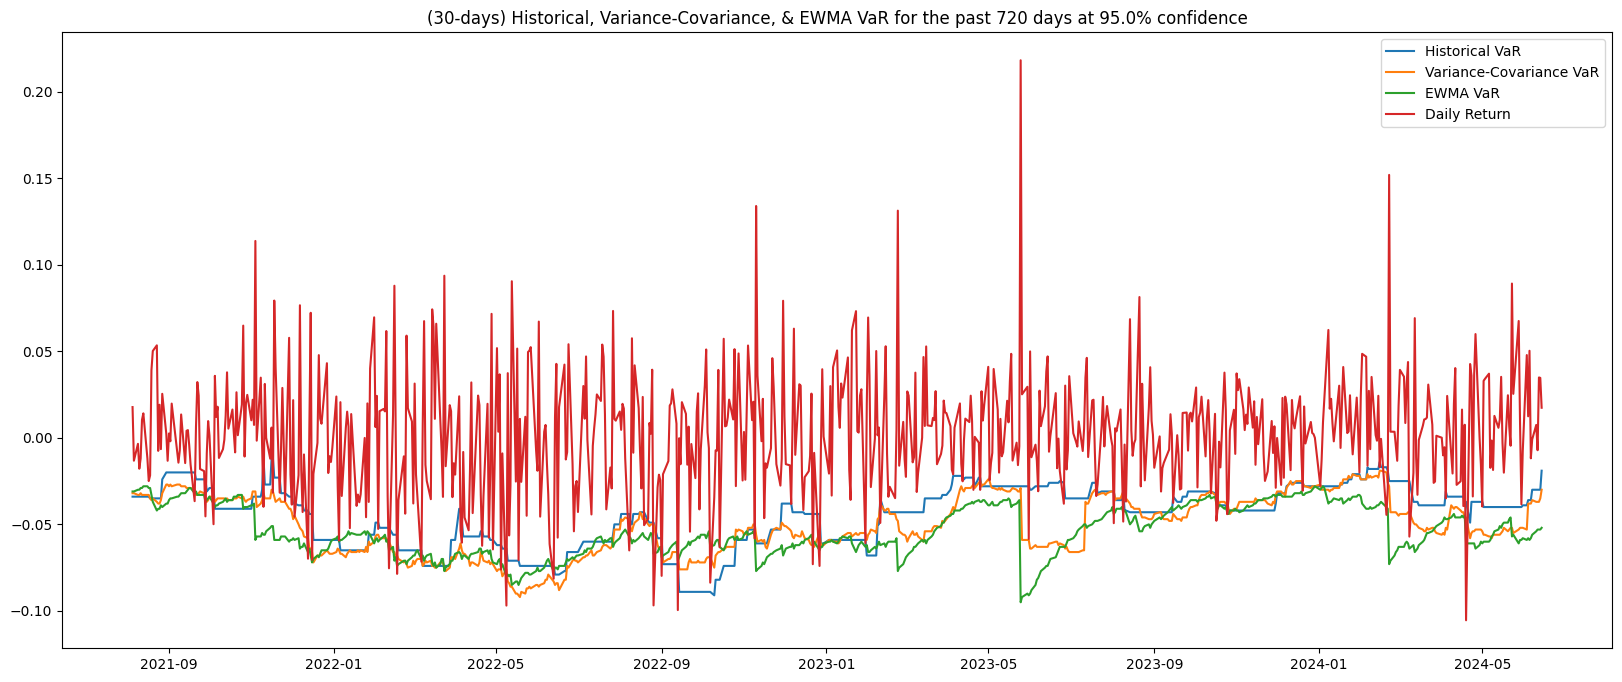

In [412]:
nvidia = Asset(ticker="NVDA", asset_class='Equity')
nvidia.retrieve_past_data(1100)
nvidia.plot_var_graphs(days=30, confidence_level=0.95, x_axis=750, ewma_lambda=0.94,  show_return=True)



[*********************100%%**********************]  1 of 1 completed


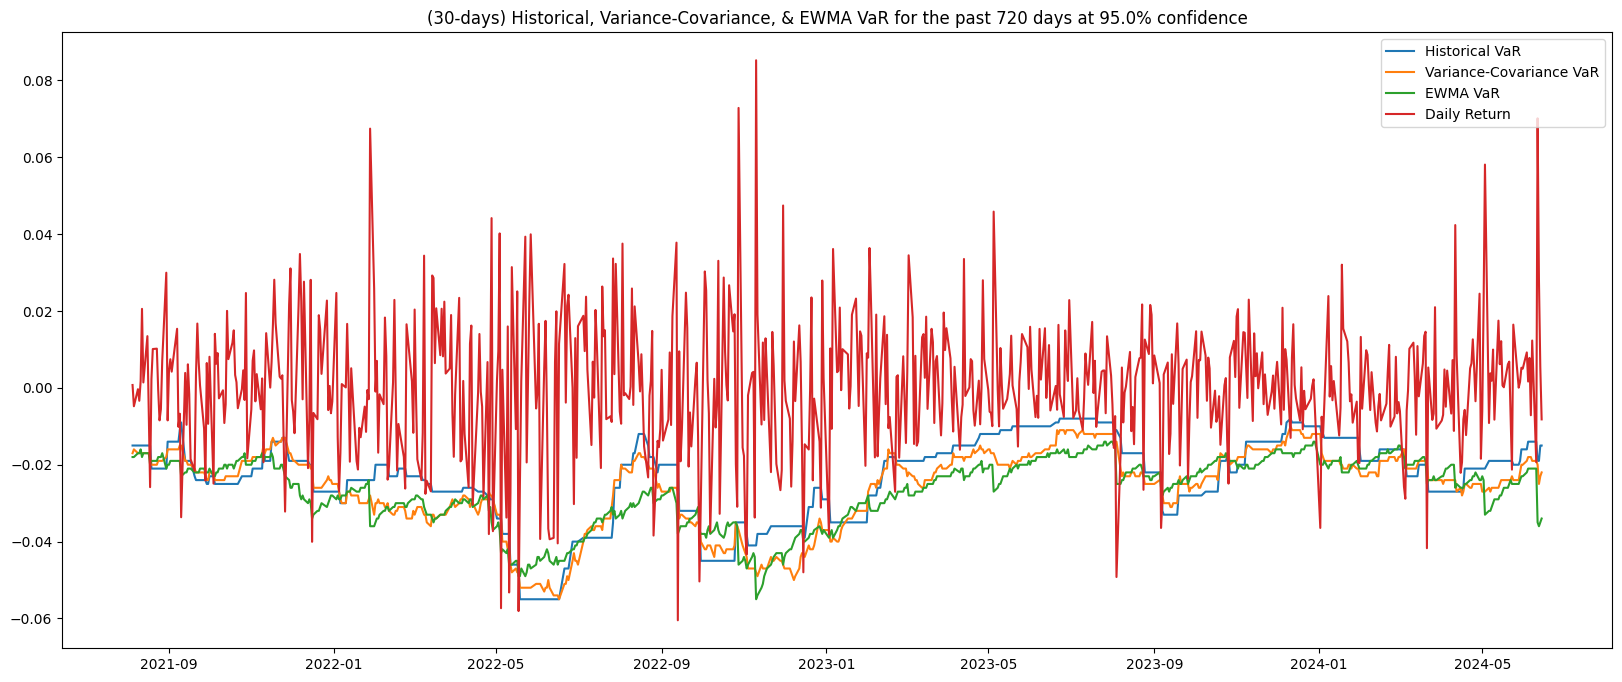

In [410]:
apple = Asset(ticker="AAPL", asset_class='Equity')
apple.retrieve_past_data(1100)
apple.plot_var_graphs(x_axis=750, days=30)


[*********************100%%**********************]  1 of 1 completed


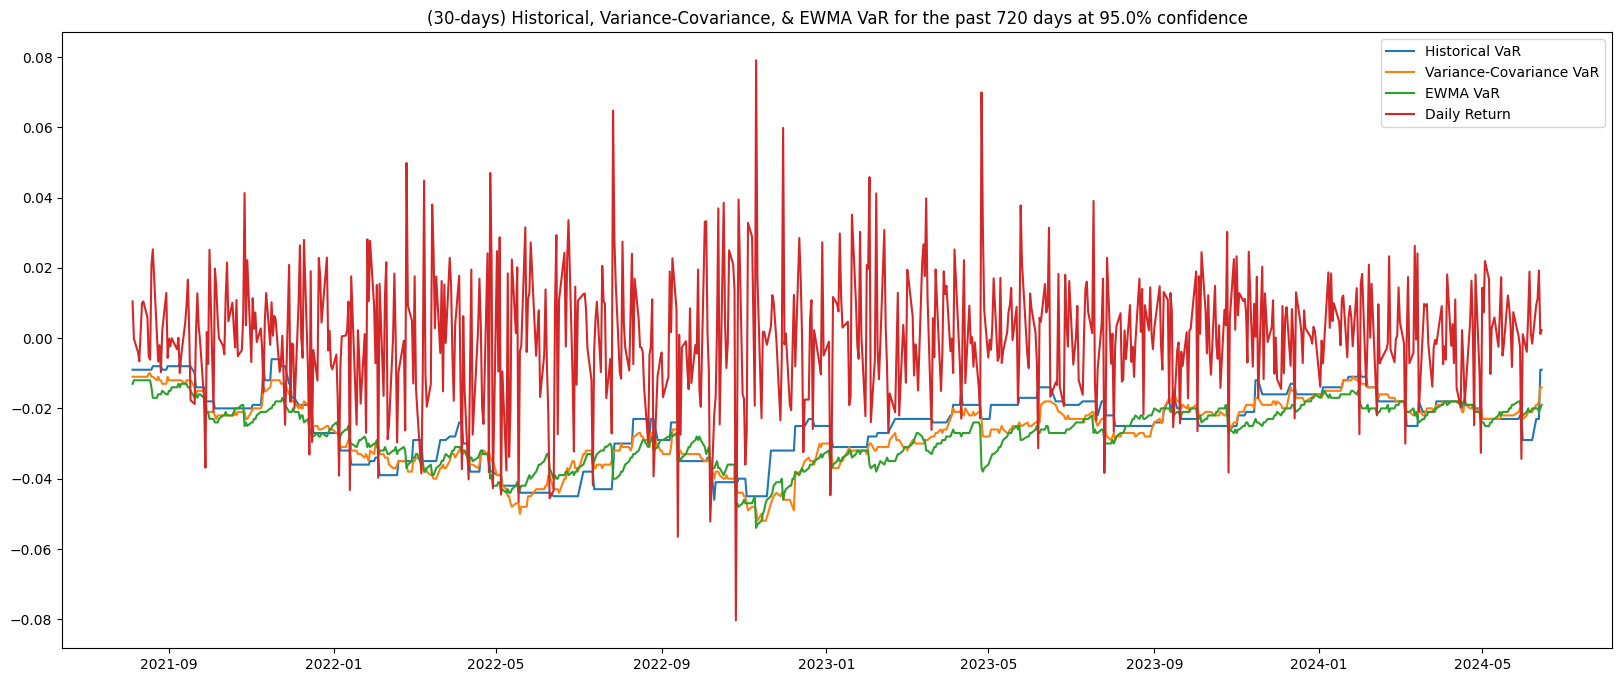

In [413]:
microsoft = Asset(ticker="MSFT", asset_class='Equity')
microsoft.retrieve_past_data(1100)
microsoft.plot_var_graphs(days=30, confidence_level=0.95, x_axis=750, ewma_lambda=0.94,  show_return=True)


The above calculations and graph illustrate a close relationship between historical VaR and the parametric VaR, which indicates that the stock's return closely follows that of a normal distribution. 

Another important observation is the apparent stickiness of the historical VaR chain. In economic terms, this occurs because quantiles can often go multiple days without experiencing any change until a significant event occurs, making the historical VaR slow to react to changes in volatility (MathWorks, 2024).

## Assessing Normality

The assumption of normality can be verified using multiple techniques:

1. The historical VaR can be compared to the normal VaR. In this case, the worst expected losses at 95% confidence for 1 year are -0.052% and -0.055% using the historicalnd variance-covariance method, which in this case are sufficiently close to each other. 

2. A more rigorous approach to determine normality of the stock return data is a Quantile-Quantile plot alongside a plot of the normal distribution with the respective returns historogram. In the QQ-plot, Data values must clearly follow the red 45-degree line to indicate normality. This would indicate that the quantiles of the returns correspond closely to the quantiles of a normal distribution with mean and standard deviation equal to those of the stock's return.

$$
\text{Return: } R_t= \frac{S_t - S_{t-1}}{S_{t-1}} = (\frac{S_t}{S_{t-1}} - 1)
$$


$$
\text{Log Return: } r_t = \ln(R_t + 1) = \ln(\frac{S_t}{S_{t-1}})
$$

where $S_i$ is the asset price on day i. Note that we do not subtract 1 when calculating log return since the logarithm of a negative value does not exist.

It is also standard practice to consider normality of the log returns, as opposed to the returns themselves, for the following reasons:

1. Symmetry: When using log-returns, the total return currently from t time steps in the past is the sum of the returns over each time step. For instance, a 5% decrease following a 5% increase in log-return restores the asset to the same price, but this is not the case with the simple return metric. This makes it easier to interpret and less misleading. For instance, if the price of an asset at time t = 1,2,3 is \$10,\$5,\$8, the returns are -0.5 and 0.6, giving an average return of 0.1. However, this overlooks the compounding effect of time as the price of the stock at time t=3 is in fact less than t=1. In this way, log return depicts a more accurate representation of price movements.
2. A log-mean of 0 implies a strictly positive expected return for the asset. Generally, returns are empirically log-normally distributed and therefore log-returns are better suited to OLS model assumptions as they address the issues of heteroskedacity (ensure similar value of variance of the residuals). By the assumption that asset prices follow geometric brownian motion, this implies that the log price of the asset follows arithmetic brownian motion. Consequently, the changes in log price are normally distributed with variance proportional to the time in between the price movements.


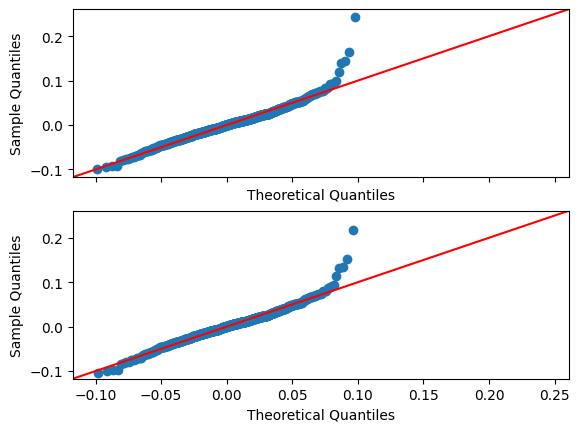

In [403]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, sharey=True)
sm.qqplot(nvidia.past_data['Returns'], loc=np.mean(nvidia.past_data['Returns']), scale=np.std(nvidia.past_data['Returns']), line='45', ax=ax1)
sm.qqplot(nvidia.past_data['Log Returns'], loc=np.mean(nvidia.past_data['Log Returns']), scale=np.std(nvidia.past_data['Log Returns']), line='45', ax=ax2)
plt.show()

The two QQ plots above depict a very similar picture with regards to normality, which can be explained by the small changes in asset prices. Normality is a powerful tool at our disposal since it enables statistical inferences and predictions to be made about the the stock's future returns.

## Further Work 1: Deploying Monte Carlo Method

* https://www.youtube.com/watch?v=X8aNFXJEENs
* https://medium.com/@serdarilarslan/value-at-risk-var-and-its-implementation-in-python-5c9150f73b0e

## Further Work 2: Determining Thresholds

In the above context, it is possible to use backtesting to determine the better choice of the following metrics:

1. Choice of VaR method between parametric, historical, EWMA Volatility, and Monte Carlo Method;
2. Confidence Threshold;
3. Number of days used to calculate Historical and Parametric VaR parameters;
4. Standard Returns vs Log Returns.

* https://www.mathworks.com/help/risk/value-at-risk-estimation-and-backtesting.html

## Further Work 3: Expected Shortfall (ES)

Let X be an integrable random variable on a probability space (Ω, F , P ) with continuous distribution. Then for α ∈ (0, 1):

$$
ES_\alpha(X) = \frac{1}{\alpha}   \int_{0}^{\alpha} VaR_\mu(X) \,d\mu 
$$

## Further Work 4: Portfolio VaR

The key to finding the Value at Risk for a portfolio is to use both its covariance matrix ($\Sigma$) as well as the weights allocated to each asset in the portfolio ($W$), as the latter allows the volatility (standard deviation) of the portfolio to be determined.

Portfolio volatility is given by:

$$

\sigma = W^T \times \Sigma \times W

$$


* https://medium.com/@akjha22/quantitative-finance-using-python-8-value-at-risk-d9e280439435
* https://www.youtube.com/watch?v=X8aNFXJEENs

# References

* https://www.investopedia.com/articles/04/092904.asp
* https://www.investopedia.com/terms/v/var.asp#toc-value-at-risk-var-example
* https://blog.quantinsti.com/calculating-value-at-risk-in-excel-python/
* https://www.investopedia.com/articles/07/ewma.asp
* https://medium.com/@gianlucabaglini/estimate-volatility-with-sma-and-ewma-in-python-744094730150